In [2]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import shap
import lime.lime_tabular
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [4]:
# Step 1: Load the dataset
file_path = 'heart_disease_uci.csv'
df = pd.read_csv(file_path)

In [5]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


# Data Cleaning and Preprocessing

In [280]:
# 2.1 Handle missing values
df = df.dropna()

In [281]:
# 2.2 Handle duplicates
df = df.drop_duplicates()

In [282]:
# 2.3 Handle outliers by Z-score method
df = df[(np.abs(stats.zscore(df.select_dtypes(include=[float, int]))) < 3).all(axis=1)]


In [283]:
# Step 3: Standardize Data Formats and Units
scaler = StandardScaler()
df[df.select_dtypes(include=[float, int]).columns] = scaler.fit_transform(df.select_dtypes(include=[float, int]))


# Descriptive Statistics

In [284]:
# 4.1 Calculate summary statistics
summary_stats = df.describe()

In [285]:
# 4.2 Calculate mean, median, and standard deviation for numeric columns
mean_values = df.select_dtypes(include=[np.number]).mean()
median_values = df.select_dtypes(include=[np.number]).median()
std_dev_values = df.select_dtypes(include=[np.number]).std()

In [286]:
# 4.3 Explore data distributions and assess skewness and kurtosis
skewness = df.select_dtypes(include=[np.number]).skew()
kurtosis = df.select_dtypes(include=([np.number])).kurtosis()

In [287]:
# Print summary statistics
print("Summary Statistics:\n", summary_stats)
print("\nMean Values:\n", mean_values)
print("\nMedian Values:\n", median_values)
print("\nStandard Deviation Values:\n", std_dev_values)
print("\nSkewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Summary Statistics:
                  id           age      trestbps          chol      thalch  \
count  2.880000e+02  2.880000e+02  2.880000e+02  2.880000e+02  288.000000   
mean  -9.868649e-17  2.744718e-16  7.617364e-16  2.744718e-16    0.000000   
std    1.001741e+00  1.001741e+00  1.001741e+00  1.001741e+00    1.001741   
min   -1.703907e+00 -2.796120e+00 -2.182524e+00 -2.586361e+00   -2.750839   
25%   -8.770912e-01 -8.110358e-01 -6.537363e-01 -7.344754e-01   -0.715857   
50%   -4.814412e-03  1.263653e-01 -6.574113e-02 -6.997526e-02    0.140391   
75%    8.674623e-01  7.329190e-01  5.222541e-01  6.380987e-01    0.718637   
max    1.717009e+00  2.497439e+00  2.874235e+00  3.252526e+00    2.319934   

          oldpeak            ca           num  
count  288.000000  2.880000e+02  2.880000e+02  
mean     0.000000 -2.467162e-17 -2.467162e-17  
std      1.001741  1.001741e+00  1.001741e+00  
min     -0.928462 -7.115579e-01 -7.518860e-01  
25%     -0.928462 -7.115579e-01 -7.518860e-01

# Feature Selection

In [288]:
# 6.1 Convert categorical columns to numerical
df_encoded = pd.get_dummies(df, drop_first=True)

In [289]:
# 6.2 Calculate the correlation matrix on the encoded dataframe
correlation_matrix = df_encoded.corr()

In [290]:
# 6.3 Select features with high correlation with the target variable 'num'
high_correlation_features = correlation_matrix.index[abs(correlation_matrix["num"]) > 0.5].tolist()
if 'age' not in high_correlation_features:
    high_correlation_features.append('age')
df_selected_features = df_encoded[high_correlation_features]

# Feature Creation

In [291]:
# 7.1 Creating a new feature 'age_group' based on 'age'
df_selected_features = df_selected_features.copy()  # Make a copy to avoid the warning
df_selected_features['age_group'] = pd.cut(df_selected_features['age'], bins=[0, 30, 40, 50, 60, 70, 80], labels=['0-30', '30-40', '40-50', '50-60', '60-70', '70-80'])


# Data Transformation

In [292]:
# 8.1 Handle categorical variables
df_transformed = pd.get_dummies(df_selected_features, drop_first=True)
# Ensure the target variable 'num' is categorical
df_transformed['num'] = df_transformed['num'].astype(int)

In [293]:
# Step 9: Display the cleaned and processed dataframe
print("\nCleaned and Processed Heart Disease Dataset:")
print(df_transformed.head())


Cleaned and Processed Heart Disease Dataset:
         ca  num  thal_normal       age  age_group_30-40  age_group_40-50  \
0 -0.711558    0        False  0.953484            False            False   
1  2.541278    0         True  1.394614            False            False   
2  1.456999    0        False  1.394614            False            False   
3 -0.711558    0         True -1.913861            False            False   
4 -0.711558    0         True -1.472731            False            False   

   age_group_50-60  age_group_60-70  age_group_70-80  
0            False            False            False  
1            False            False            False  
2            False            False            False  
3            False            False            False  
4            False            False            False  


# Model Selection, Training, and Validation

In [294]:
# 11.1 Split data into training, validation, and test sets
X = df_transformed.drop(columns=['num'])
y = df_transformed['num']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [295]:
# Step 11.2: Apply SMOTE to handle imbalanced classes
smote = SMOTE(random_state=42, k_neighbors=min(3, len(X_train)-1))
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)



In [296]:
# Creating a transformer to convert DataFrame to array
def df_to_array(df):
    return df.values

df_to_array_transformer = FunctionTransformer(df_to_array, validate=False)

In [297]:

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


# Hyperparameter Tuning

In [298]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [299]:
# Train the model with the best parameters
grid_search.fit(X_train_smote, y_train_smote)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [300]:
# Validation
y_val_pred = grid_search.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        35
           1       0.60      0.50      0.55         6
           2       0.00      0.00      0.00         2

    accuracy                           0.81        43
   macro avg       0.49      0.47      0.48        43
weighted avg       0.79      0.81      0.80        43



In [301]:
# Testing
y_test_pred = grid_search.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))


Test Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        34
           1       0.22      0.29      0.25         7
           2       0.00      0.00      0.00         3

    accuracy                           0.68        44
   macro avg       0.35      0.37      0.36        44
weighted avg       0.67      0.68      0.68        44



In [302]:
# Best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


In [303]:
# Performance Metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test), multi_class='ovr')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.6818181818181818
Precision: 0.6717171717171717
Recall: 0.6818181818181818
F1 Score: 0.6761363636363636
ROC AUC Score: 0.6378489013711395


In [304]:
# Binarize the output based on the actual classes in y_test
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]


In [305]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], grid_search.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

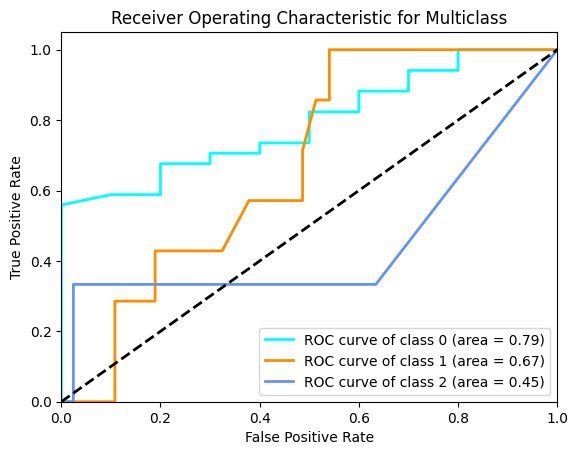

In [306]:
# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()

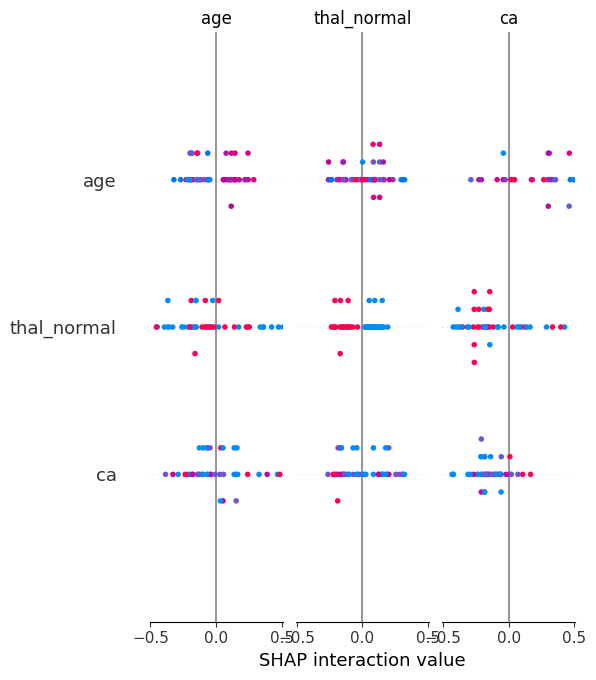

In [307]:
# Model Interpretation with SHAP
explainer = shap.TreeExplainer(grid_search.best_estimator_.named_steps['classifier'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
# Model Interpretation with LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_smote.to_numpy(), feature_names=X_train.columns.to_list(), class_names=['No Disease', 'Disease'], discretize_continuous=True)
i = 0
lime_exp = lime_explainer.explain_instance(X_test.iloc[i].to_numpy(), grid_search.predict_proba, num_features=10)
lime_exp.show_in_notebook(show_table=True, show_all=False)
